# SVBench

## Load reference calls

Download reference call sets from GIAB: [HG002](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_SVs_Integration_v0.6/HG002_SVs_Tier1_v0.6.vcf.gz),
[NA12878](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/technical/svclassify_Manuscript/Supplementary_Information/Personalis_1000_Genomes_deduplicated_deletions.bed)

Decompress HG002. We will utilize an input folder `"../benchmark_ngs"` and place reference and query SV calls there for convenience. 

Reference calls are then loaded into a data object:

In [2]:
import io_tools 

ref_data = dict()

# Vcf format
#ref_data = io_tools.load_vcf("../benchmark_ngs/HG002_SVs_Tier1_v0.6.vcf",
#                             name="HG002", data=ref_data, slop=100, tree=True)

# Load reference calls in bed format
ref_data = io_tools.load_ref_bed("../benchmark_ngs/Personalis_1000_Genomes_deduplicated_deletions.bed",
                             name="NA12878", data=ref_data, slop=100)


NA12878 loaded rows 2676


Internally, all reference calls are converted to a bedpe format - an interval is created around each breakpoint of size +/- `slop`. The `slop` value controls the maximum distance a query call can be from a reference call to be identified as a match.

Note, the vcf loader requires an "END" tag in column 7 to work properly.
For translocations, calls should instead be manually converted to bedpe and loaded with the `ref_tools.load_bedpe` function, also note that no `slop` is added to calls in bedpe format automatically.
The `ref_data` object has the structure:
```python
ref_data = {'HG002':  {'tree': overlap_object, 'bedpe': pandas_dataframe},
            'NA12878': {'tree': overlap_object, 'bedpe': pandas_dataframe}}
```

The `overlap_object` is a `dict`; keys are chromosomes and values are [nested containment list's](https://github.com/biocore-ntnu/ncls), used for testing overlap queries.

To manually construct the `overlap_object`, the function `io_tools.make_tree` can be used, note `slop` argument to create an interval around the break:

```python
# List of SVs in the form (chrom1, breakpoint1, chrom2, breakpoint2)
regions = [("chr1", 10000, "chr1", 20000), ("chr3", 7500, "chr4", 25000)]  
overlap_object = io_tools.make_tree(regions, slop=100)

# Or bedpe format can be used to manually set slop (chrom1, start1, end2, chrom2, start2, end2
regions = [("chr1", 10000, 10100, "chr1", 20000, 200100), ("chr3", 7500, 7600, "chr4", 25000, 25100)] 
overlap_object = io_tools.make_tree(regions, bedpe=True)
```

## Load query calls

Calls can be loaded from a vcf file supporting formats in the style of [lumpy](https://github.com/arq5x/lumpy-sv), [delly](https://github.com/dellytools/delly), [gridss](https://github.com/PapenfussLab/gridss), [tiddit](https://github.com/SciLifeLab/TIDDIT), or dysgu.
Or calls can be loaded from a .tsv or .csv file, but column information may need to be supplied using `break_cols` argument e.g. `break_cols="chrom,start,chrom2,end"`.

The `name` convention for query calls is a tuple `(caller_name, reference_calls)`

In [4]:
import io_tools

query_data = dict()

# Load delly calls
query_data = io_tools.load_vcf("../benchmark_ngs/NA12878.delly.bwa.mapq0.vcf", name=("delly", "NA12878"),
                               data=query_data, weight_field="PE", allowed_svtypes="DEL,DUP,INV")

# Load dysgu calls .csv format
query_data = io_tools.load_csv("../benchmark_ngs/NA12878.bwa.bamreads_fast.dysgu19.merged.csv", name=("dysgu", "NA12878"),
                               data=query_data, weight_field="pe", allowed_svtypes="DEL,DUP,INV")

# Load tiddit calls
query_data = io_tools.load_vcf("../benchmark_ngs/NA12878.tiddit.bwa.mapq0.vcf", name=("tiddit", "NA12878"),
                               data=query_data, weight_field="LTE", allowed_svtypes="DEL,DUP,INV,TDUP")

# Load lumpy calls
query_data = io_tools.load_vcf("../benchmark_ngs/NA12878.lumpy.bwa.mapq20.vcf", name=("lumpy", "NA12878"),
                               data=query_data, weight_field="SU", allowed_svtypes="DEL,DUP,INV")

('delly', 'NA12878') loaded rows 33815
('dysgu', 'NA12878') loaded rows 68856
('tiddit', 'NA12878') loaded rows 15462
('lumpy', 'NA12878') loaded rows 36595


`query_data` takes the form:
```python
query_data = {('lumpy', 'HG002'):  {'tree': None, 'bedpe': pandas_dataframe}, ... }
```

The `weight_field` argument is used for breaking potential duplicate True Positive calls that match a reference call - if one or more query calls match a reference call, the query call with the maximum weight is chosen as the True Positive, whilst others are marked as Duplicate True Positives. If two calls have the same weight, the call with the smallest absolute breakpoint distance is used.

## Score query calls against reference



In [5]:
import quant_tools

query_data = quant_tools.score(ref_data, query_data)

Scoring delly against NA12878
Total calls: 33815
Duplicate True Positives (DTP): 212
True Positives (TP): 1355
False Positives (FP = Total - TP - DTP): 32248
False Negatives (FN): 1321
---------------------------------------------
Scoring dysgu against NA12878
Total calls: 68856
Duplicate True Positives (DTP): 14
True Positives (TP): 2172
False Positives (FP = Total - TP - DTP): 66670
False Negatives (FN): 504
---------------------------------------------
Scoring tiddit against NA12878
Total calls: 15462
Duplicate True Positives (DTP): 1
True Positives (TP): 1590
False Positives (FP = Total - TP - DTP): 13871
False Negatives (FN): 1086
---------------------------------------------
Scoring lumpy against NA12878
Total calls: 36595
Duplicate True Positives (DTP): 3
True Positives (TP): 2134
False Positives (FP = Total - TP - DTP): 34458
False Negatives (FN): 542
---------------------------------------------


For each key in `query_data`, a summary scores table is created:
```python
query_data = {('lumpy', 'NA12878') : {'scores' : {'TP': 2134, 'FN': 542, ...},
                                      'bedpe': pandas_dataframe, 
                                      'FN_indexes': set([indexes])...} ...}
```
The bedpe table has additional columns added `FP`, `TP` and `DTP`, with values `True` or `False`, and `ref_index` which holds the index into ref_data

Also FN events can be found in `query_data[key]['FN_indexes']`, this provides a set of indexes into ref_data where False Negative calls can be assessed.


## Plotting data
Next generate simple plots for the query calls

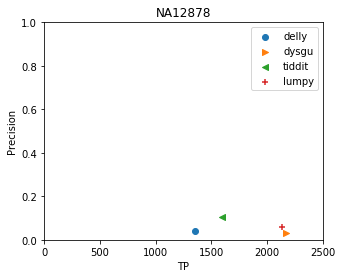

In [5]:
plots = quant_tools.plot(query_data, x="TP", y="Precision")

The `plot` function returns a `dict` with keys corresponding to the reference dataset and values are matplotlib.pyplot objects:
```python
plots = {'NA12878': matplotlib.pyplot, ...}
```
This allows further customization of plots if needs be before saving with `plots['NA12878'].savefig("example.pdf")`

## Filtering and stratifying calls

Input calls often need to be filtered before further analysis. Calls are usually hard-filtered using the FILTER column e.g. keeping calls with a 'PASS' label. Calls can further be stratified using an additional column, for example by a quality value or using the number of supporting reads. Filters and stratification can be performed in SVBench as data is loaded, although this can be slightly arduous as vcf's can be formatted in several ways. Also one has to pay attention to how parsing instructions are outlined in the vcf header, as this can influence how the vcf is parsed. Examples are given below.

In [6]:
import io_tools

query_data = dict()

# Limit calls to target chromosomes only
target_chroms = set(["chr" + str(i) for i in range(1, 23)] + ["chrX", "chrY"])

# Load delly calls
query_data = io_tools.load_vcf("../benchmark_ngs/NA12878.delly.bwa.mapq0.vcf",
                               name=("delly", "NA12878"), data=query_data, weight_field="PE",
                               allowed_chroms=target_chroms,
                               keep=[("FORMAT", "FT", "eq", "PASS"), ("INFO", "MAPQ", "gt", "20")],
                               stratify=("FORMAT", "DV", range(0, 60, 5)),
                               size_range=(50, None))

('delly', 'NA12878') loaded rows 2440


The `keep` argument can take a `list` detailing a succession of filtering steps, which are each described in a `tuple` format. The tuple can be of length 3 or 4. As an example:  
```python
keep = [("FORMAT", "FT", "eq", "PASS"), ...]
```
This step will look in the "FORMAT" column, select the "FT" value (filter) and test it with the equality ("eq") operator against the string "PASS". Any operator can be used from the python [Operator](https://docs.python.org/3/library/operator.html) module, for example le - less or equal, lt - less than etc. Only if all steps in `keep` return a `True` value will the record be kept. 

Note, numerical values are parsed to a `float` before comparison. Occationally values will parse to a `list`, if this is the case then the first value of the list is used for comparison. Finally, an empty list will sometimes be parsed (see tiddit exmaple below), and will take the value of `None` in comparison operations.

```python
stratify=("FORMAT", "DV", range(0, 60, 5)
```
The `stratify` argument is a tuple or length 2 or 3, detailing the desired column to stratify the data by. The example above will stratify data by `'SU'` or support, in the range 0 to 50, with a step of 5. The third value of the tuple can be any numeric iterable for example `np.linspace` also works. 

```python
size_range=(50, None)
```
The minimum or maximum size of intra-chromosomal SVs can be controlled with `size_range` argument. Here we are ensuring SVs less than 50bp are filtered out, and there is no maximum size indicated with `None`. 

In [7]:
# Load tiddit calls, note 'PASS' is parsed as None because it is not defined in the vcf FILTER column header
query_data = io_tools.load_vcf("../benchmark_ngs/NA12878.tiddit.bwa.mapq0.vcf", name=("tiddit", "NA12878"),
                               data=query_data, weight_field="LTE",
                               allowed_chroms=target_chroms,
                               keep=[("FILTER", "eq", None)],
                               stratify=("INFO", "LTE", range(0, 60, 5)),
                               size_range=(50, None))

# Load lumpy calls
query_data = io_tools.load_vcf("../benchmark_ngs/NA12878.lumpy.bwa.mapq20.vcf",
                               name=("lumpy", "NA12878"), data=query_data, weight_field="SU",
                               allowed_chroms=target_chroms,
                               keep=[("INFO", "SU", "gt", 3)],
                               stratify=("INFO", "SU", range(0, 60, 5)),
                               size_range=(50, None))

('tiddit', 'NA12878') loaded rows 1809
('lumpy', 'NA12878') loaded rows 3926


In [8]:
import quant_tools

query_data = quant_tools.score(ref_data, query_data)

Scoring delly against NA12878
Total calls: 2440
Duplicate True Positives (DTP): 0
True Positives (TP): 671
False Positives (FP = Total - TP - DTP): 1769
False Negatives (FN): 2005
---------------------------------------------
Scoring tiddit against NA12878
Total calls: 1809
Duplicate True Positives (DTP): 0
True Positives (TP): 1498
False Positives (FP = Total - TP - DTP): 311
False Negatives (FN): 1178
---------------------------------------------
Scoring lumpy against NA12878
Total calls: 3926
Duplicate True Positives (DTP): 0
True Positives (TP): 2077
False Positives (FP = Total - TP - DTP): 1849
False Negatives (FN): 599
---------------------------------------------


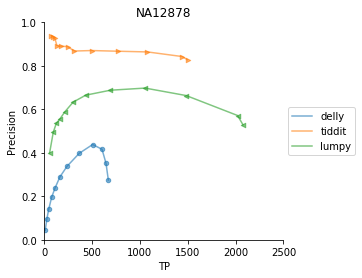

In [9]:
plots = quant_tools.plot(query_data, x="TP", y="Precision")

## Calibrating calls with ML

Additional information can be scraped from input files, and these can be used as features to train a classifier using the reference calls as training data. For each parameter in the input file that you want to assess, SVBench must be given instructins on how to process it. This is achived by providing parse instructions during loading of the data. 

In [ ]:
parse_model = {}
